In [1]:
# necessary packages to import 
import numpy as np

In [1]:
'''
Examples:
1. submit structures to aiida workchains
2. read data from aiida workchains as AiidaMofs object
3. two ways to plot results
'''


from isotherm import generateconfig, submit_mof, submit_mofs

ff_data = "UFF.json"
cif_path = "/home/yutao/project/Al-MOF/mil121/RSM0112.cif"
isotherm_path = "/home/yutao/project/Al-MOF/mil121/273K.csv"
output_name = "test.log"
temperature = 303
data = np.loadtxt(isotherm_path, delimiter=',')
pressure_list = list(data[:,0])
generateconfig(ff_data, temperature, pressure_list, cif_path, output_name)
submit_mof(output_name)

# submit workchains for all mofs in structure_path
structure_path = "/home/yutao/project/Al-MOF/"
ff_data = "try_0226.json"
submit_mofs(structure_path, ff_data)

As long as it finishes, 0
The tested force field is:  UFF.json
The tested cif is:  /home/yutao/project/Al-MOF/mil121/RSM0112.cif
The simulation temperature is:  303
This is the final pk values for isotherm workflow:  820282



Wrong output dict, num: 1, in workchain 778663, CPM-203
UFF
778558
/home/yutao/project/Mg-MOF/MOF-889
RSM3831.cif
UFF
778602
/home/yutao/project/Mg-MOF/CPM-201
RSM3545.cif
UFF
778646
/home/yutao/project/Mg-MOF/CPM-203
RSM0100.cif
UFF
778692
/home/yutao/project/Mg-MOF/HAFVUH
RSM0639.cif


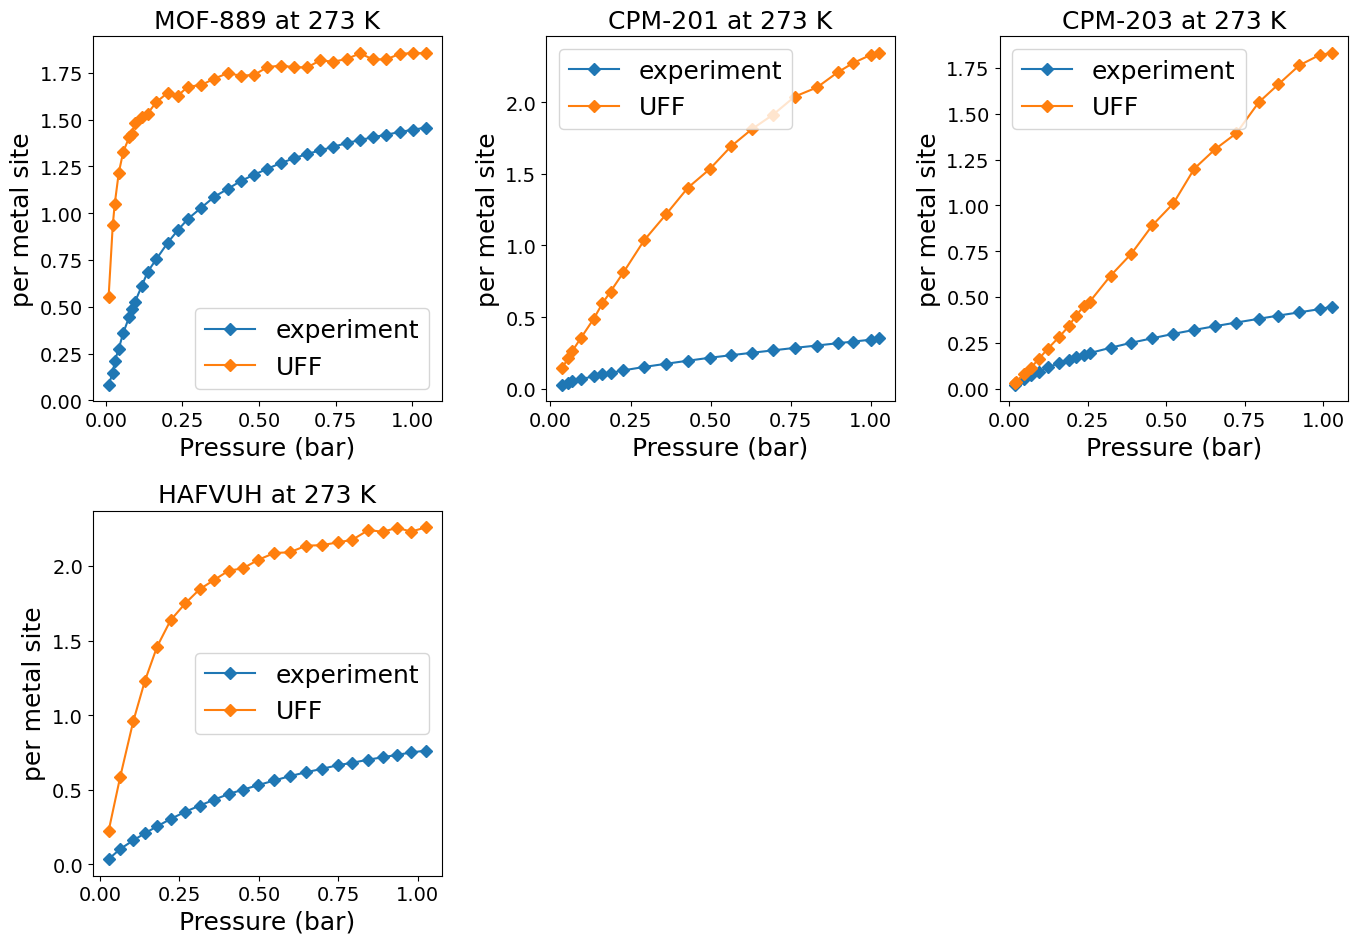

In [1]:
from aiidamof import AiidaMofs, plot_isotherm
import numpy as np
log_name = "UFF_Mg.log"
aiida_mofs = AiidaMofs(log_name)
# Get an AiidaMof object
aiida_mof = aiida_mofs[0]
# Print the folder of the AiidaMof object
for aiida_mof in aiida_mofs:
    print(aiida_mof.forcefield)
    print(aiida_mof.isotherm_pk)
    print(aiida_mof.folder)
    print(aiida_mof.cifname)
plot_isotherm(aiida_mofs)

In [16]:
'''
Hello, this part is to analysis the output information from aiida workchain and 
compare them with DFT-level binding energy and experiental isotherms

The input is *.log file, which format looks like
The tested force field is:  try_0226.json
The tested cif is:  /home/yutao/project/Al-MOF/WOJJOV/RSM2706.cif
The simulation temperature is:  195
This is the final pk values for isotherm workflow:  781611
This is the final pk values for binding sites workflow:  781629
The file is stored in aiida_path (default)
'''

# The aiida working directory, it changes when it moves to other computer
aiida_path = "/home/yutao/project/aiida/applications/"




from aiida.orm import QueryBuilder, Group, WorkChainNode, Dict, StructureData, CifData
import aiida
import numpy as np
import pytest
import os
from ase.io import read, write
aiida.load_profile()
import pytest



# Default global variable "mol/kg" or "per unit cell"
Isotherm_unit = "per unit cell" 
# Ioshterm_unit is controlled by Isotherm_unit, energy_unit = binding_energy
class AiidaMof: 
    # forcefield must be the first line. folder mofname are also necessary for a AiidaMof object
    def __init__(self, folder, cifname, mofname,forcefield, temperature=None, isotherm_pk=None, binding_pk=None):
        # there are some default choice you can change in a class
        self.folder = folder
        self.mofname = mofname
        self.cifname = cifname
        self.temperature = temperature
        self.isotherm_pk = isotherm_pk
        self.binding_pk = binding_pk
        self.forcefield = forcefield
        self.exp_pressure = None
        self.exp_loading = None # this is a list
        self.ff_pressure = None
        self.ff_loading = None # this is a list
        self.ff_energy = None 
        self.dft_energy = None
        self.co_isotherms = None # this is a directories included points with the same pressure from simulated isotherms and experimental isotherms
    @staticmethod
    def compute_molar_mass(atoms):
        return sum(atom.mass for atom in atoms)
    @staticmethod
    def extract_same_pressure_points(exp_pressure, exp_loading, ff_pressure, ff_loading, error=0.01):

        co_pressures = []
        exp_part = []
        ff_part = []

        for p1, l1 in zip(exp_pressure, exp_loading):
            for p2, l2 in zip(ff_pressure, ff_loading):
                if abs(p1 - p2) / p1 < error:
                    co_pressures.append(p1)
                    exp_part.append(l1)
                    ff_part.append(l2)
                    break
        return co_pressures, exp_part, ff_part
    def set_isotherm(self):
        try:
            qb = QueryBuilder()
            qb.append(WorkChainNode, filters={'id':self.isotherm_pk}, tag="workchain")
            qb.append(Dict, with_incoming="workchain")
            outdict_ls = qb.all()[:]
            self.ff_pressure = np.array(outdict_ls[0][0].get_dict()['isotherm']['pressure'])
            if Isotherm_unit == "mol/kg":
                self.ff_isotherm = outdict_ls[0][0].get_dict()['isotherm']['loading_absolute_average']
            elif Isotherm_unit == "per unit cell":
                atoms = read(os.path.join(self.folder, self.mofname))
                molar_mass = self.compute_molar_mass(atoms)
                self.ff_isotherm = np.array(outdict_ls[0][0].get_dict()['isotherm']['loading_absolute_average'])*molar_mass/1000
        except:
            print("Isotherm workflow failed for ", self.isotherm_pk, self.mofname)
        
        # read experimental isotherms from {Temperature}K.csv
        exp_path = os.path.join(self.folder, f"{self.temperature}K.csv")
        exp_isotherm = np.loadtxt(exp_path, delimiter=',')
        if Isotherm_unit == "mol/kg":
            transfer_unit = 1/22.5 #from STP to mol/Kg
        elif Isotherm_unit == "per unit cell":
            transfer_unit = 1/22.5*1000/molar_mass
        else:
            raise ValueError("Wrong global unit for isotherm")
        self.exp_loading = exp_isotherm[:,1]*transfer_unit
        self.exp_pressure = exp_isotherm[:,0] # unit bar
    def set_binding(self):
        binding_pk = self.binding_pk
        qb = QueryBuilder()
        qb.append(WorkChainNode, filters={'id':binding_pk}, tag="workchain")
        workchain = qb.all()[:][0][0]
        if not workchain.is_finished:
            print(f"WorkChain with pk={binding_pk} has not finished yet.")
        qb.append(Dict, with_incoming="workchain")
        outdict_ls = qb.all()[:]
        if len(outdict_ls)==2:
            try:
                self.ff_energy = outdict_ls[0][0]["energy_host/ads_tot_final"][-1]
                self.dft_energy = outdict_ls[1][0]["binding_energy_corr"]
            except:
                self.ff_energy = outdict_ls[1][0]["energy_host/ads_tot_final"][-1]
                self.dft_energy = outdict_ls[0][0]["binding_energy_corr"]
            

        else:
            print(f"Wrong output dict, num: {len(outdict_ls)}, in workchain {binding_pk}, {self.mofname}")
    def compare_isotherm(self):
        co_pressures, exp_part, ff_part = self.extract_same_pressure_points(self.exp_pressure, self.exp_loading, self.ff_pressure, self.ff_isotherm)
        self.co_isotherms = {"pressure": co_pressures, "exp_part": exp_part, "ff_part": ff_part}
        
    def extractdata(self):
        self.set_isotherm()
        self.set_binding()
        self.compare_isotherm()
        
class AiidaMofs:
    def __init__(self, log_name, isdefaultpath=True):
        if isdefaultpath:
            log_path = os.path.join(aiida_path, log_name) # os.path.join can delete overlap of path automatically
        else:
            log_path = log_name
        self.mofs = self.log_file(log_path)
        self.extractdata()
    def __len__(self):
        return len(self.mofs)

    def __getitem__(self, index):
        return self.mofs[index]

    def __setitem__(self, index, value):
        self.mofs[index] = value

    def __delitem__(self, index):
        del self.mofs[index]
    def extractdata(self):
        for mof in self.mofs:
            mof.extractdata()
    @staticmethod
    def log_file(log_path):
        mofs = []
        aiida_mof = None
        with open(log_path, 'r') as f:
            lines = f.readlines()
            for line in lines:
                if "The tested force field is:" in line:
                    forcefield = os.path.splitext(line.split()[-1])[0]
                if "The tested cif is:" in line:
                    if aiida_mof is not None:
                        mofs.append(aiida_mof)
                    path = line.split()[-1]
                    folder = os.path.dirname(path)
                    parts = os.path.normpath(path).split(os.sep)
                    cifname = parts[-1]
                    mofname = parts[-2]
                    aiida_mof = AiidaMof(folder, mofname, cifname,  forcefield)
                if aiida_mof is not None:
                    if "The simulation temperature is:" in line:
                        aiida_mof.temperature = int(line.split()[-1])
                    if "This is the final pk values for isotherm workflow:" in line:
                        aiida_mof.isotherm_pk = int(line.split()[-1])
                    if "This is the final pk values for binding sites workflow:" in line:
                        aiida_mof.binding_pk = int(line.split()[-1])
            if aiida_mof is not None:
                mofs.append(aiida_mof)
        return mofs


# this is a simple tool to read log file and I just do not want to delete it
def read_log(log_path):
    folders = []
    mofnames = []
    temperatures = []
    isothermpks = []
    bindingpks = []
    with open(log_path, 'r') as f:
        lines = f.readlines()
        for line in lines:
            if "The tested cif is:" in line:
                folders.append(line.split()[-1])
                mofnames.append(line.split("/")[-1].split(".")[0])
            if "The simulation temperature is:" in line:
                temperatures.append(int(line.split()[-1]))
            if "This is the final pk values for isotherm workflow:" in line:
                isothermpks.append(int(line.split()[-1]))
            if "This is the final pk values for binding sites workflow:" in line:
                bindingpks.append(int(line.split()[-1]))
    return folders, mofnames, temperatures, isothermpks, bindingpks

if __name__ == "__main__":

    log_name = "UFF_Mg.log"
    log_path = os.path.join(aiida_path, log_name)
    aiida_mofs = AiidaMofs(log_path)
    # Get an AiidaMof object
    aiida_mof = aiida_mofs[0]
    # Print the folder of the AiidaMof object
    for aiida_mof in aiida_mofs:
        print(aiida_mof.forcefield)
        print(aiida_mof.isotherm_pk)
        print(aiida_mof.folder)
        print(aiida_mof.co_isotherms)


Wrong output dict, num: 1, in workchain 778663, RSM0100.cif
UFF
778558
/home/yutao/project/Mg-MOF/MOF-889
{'pressure': [0.008996854700854706, 0.022492136752136748, 0.028980040337675688, 0.042095334367576946, 0.05680552247667515, 0.07596747803984254, 0.08434551282051281, 0.09512943360300993, 0.11673018351058044, 0.13624053826580543, 0.1641124736304126, 0.20243638475674738, 0.23448911042604553, 0.26793543286357413, 0.3111369326787152, 0.35433843249385616, 0.39753993230899726, 0.44074143212413824, 0.48394293193927934, 0.5271444317544204, 0.5703459315695615, 0.6135474313847024, 0.6567489311998435, 0.6999504310149846, 0.7431519308301257, 0.7863534306452666, 0.8295549304604076, 0.8727564302755487, 0.9159579300906897, 0.9591594299058308, 1.002360929720972, 1.0441688327678826], 'exp_part': [0.058378527095818346, 0.10315500442749784, 0.14636339435397658, 0.19343103674869455, 0.2523133994341747, 0.3117003517330539, 0.34063944085003367, 0.3684753226897568, 0.42637111707805153, 0.48006305023755985

In [7]:
import os

path = "/home/yutao/project/Mg-MOF/HAFVUH/RSM0639.cif"
parts = os.path.normpath(path).split(os.sep)

print(parts)

['', 'home', 'yutao', 'project', 'Mg-MOF', 'HAFVUH', 'RSM0639.cif']


In [19]:
structure_folder = "/home/yutao/project/Mg-MOF/MOF-889/"
SET_temperature = 273
Index = 1
Transfer_unit = 14.835925/4.398046  #It also depends on different structure, it also contains transfer from STP to mol/Kg
cif_path = os.path.join(structure_folder, "RSM3831.cif")
scaling_factors = (2,2,1)  
experiment_path = os.path.join(structure_folder, f"{SET_temperature}K_short.csv")
dest_path = f"/home/yutao/project/MIL-120/traj{Index}/"
copy_to_path = f"./traj{Index}/"
ff_path = f'/home/yutao/project/aiida/applications/ff_{Index}.json'


In [20]:
def compute_molar_mass(atoms):
    return sum(atom.mass for atom in atoms)
atoms = read(cif_path)
molar_mass = compute_molar_mass(atoms)
print(molar_mass/1000-Transfer_unit)

3.681213337269895e-05


In [10]:
molar_mass = compute_molar_mass(atoms)

NameError: name 'compute_molar_mass' is not defined

In [15]:
log_path

'/home/yutao/project/aiida/applications/UFF_Mg.log'

In [11]:
log_name = "UFF_Mg.log"
log_path = os.path.join(aiida_path, log_name)
aiida_mofs = AiidaMofs(log_path)

# Get an AiidaMof object
aiida_mof = aiida_mofs[0]

# Print the folder of the AiidaMof object
for aiida_mof in aiida_mofs:
    print(aiida_mof.folder)

/home/yutao/project/Mg-MOF/MOF-889/RSM3831.cif
/home/yutao/project/Mg-MOF/CPM-201/RSM3545.cif
/home/yutao/project/Mg-MOF/CPM-203/RSM0100.cif
/home/yutao/project/Mg-MOF/HAFVUH/RSM0639.cif


CIF files: ['MOF-889', 'CPM-201', 'CPM-203', 'HAFVUH']
Temperatures: [273, 273, 273, 273]
Isotherm PKs: [778558, 778602, 778646, 778692]
Binding PKs: [778574, 778619, 778663, 778707]


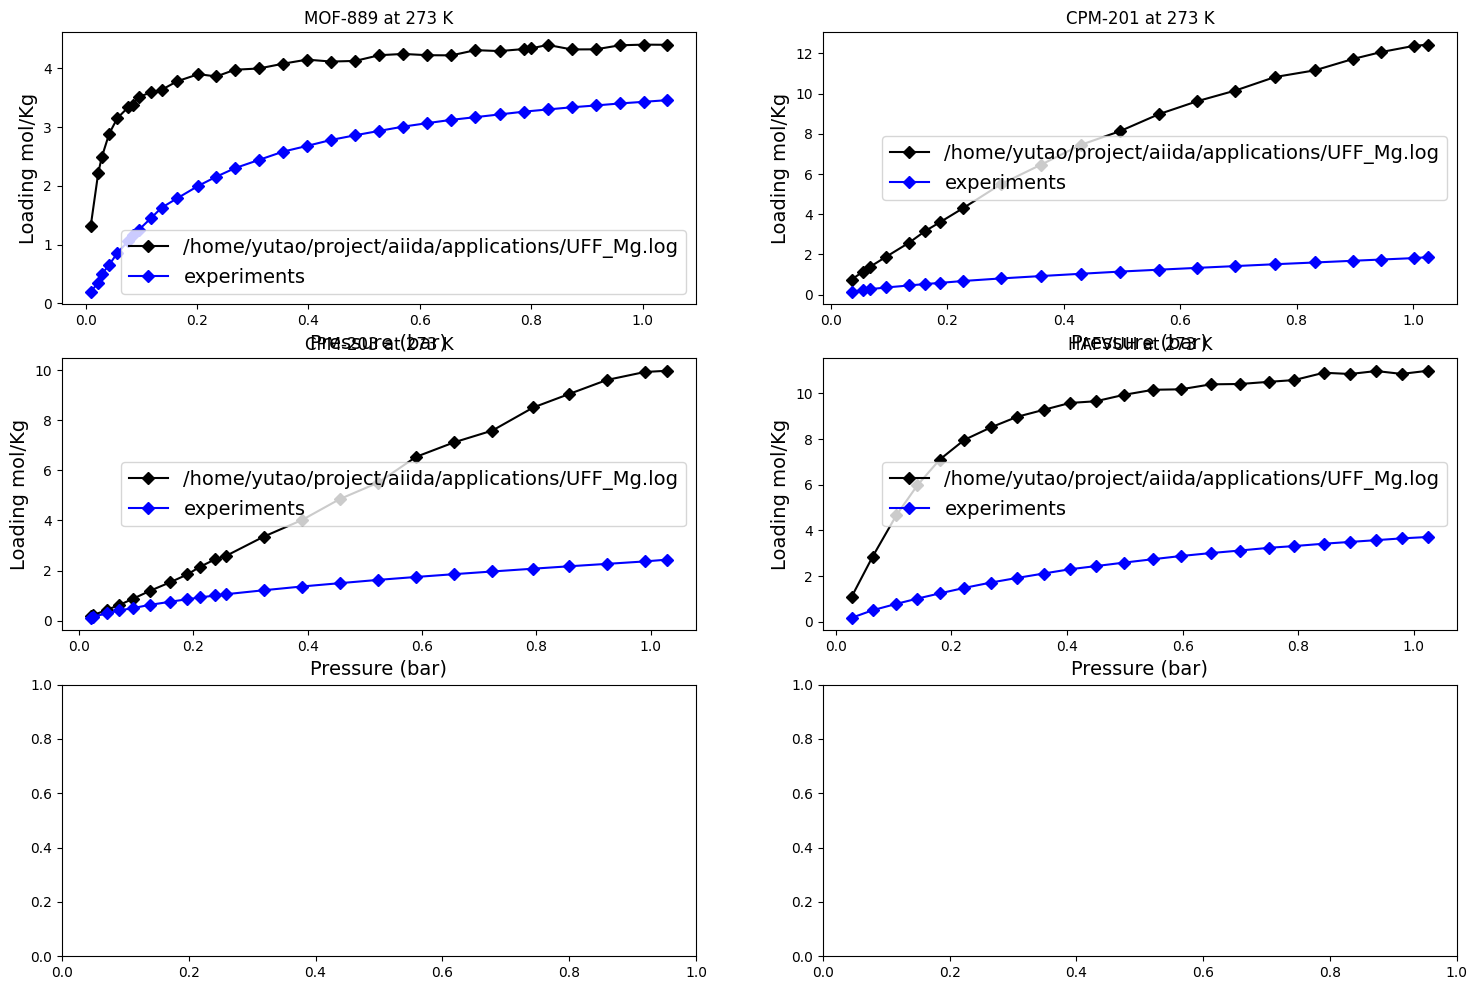

In [5]:
structure_path = "/home/yutao/project/Mg-MOF/"

import re
import os
log_name = "UFF_Mg.log"

folder_names = []
temperatures = []
isotherm_pks = []
binding_pks = []

log_name = os.path.join(aiida_path, log_name)
with open(log_name, 'r') as f:
    for line in f:
        if 'The tested cif is:' in line:
            cif_file = re.search(r'The tested cif is:  (.*)', line).group(1)
            folder_name = os.path.basename(os.path.dirname(cif_file))
            folder_names.append(folder_name)
        elif 'The simulation temperature is:' in line:
            temperature = re.search(r'The simulation temperature is:  (\d+)', line).group(1)
            temperatures.append(int(temperature))
        elif 'This is the final pk values for isotherm workflow:' in line:
            isotherm_pk = re.search(r'This is the final pk values for isotherm workflow:  (\d+)', line).group(1)
            isotherm_pks.append(int(isotherm_pk))
        elif 'This is the final pk values for binding sites workflow:' in line:
            binding_pk = re.search(r'This is the final pk values for binding sites workflow:  (\d+)', line).group(1)
            binding_pks.append(int(binding_pk))

print("CIF files:", folder_names)
print("Temperatures:", temperatures)
print("Isotherm PKs:", isotherm_pks)
print("Binding PKs:", binding_pks)


import matplotlib.pyplot as plt
import math

fz = 14

Number_of_pictures = len(folder_names)
fig, axs = plt.subplots(3, math.ceil(Number_of_pictures/3), figsize=(3*6, math.ceil(Number_of_pictures/3)*6))
idx_ls = []
for i in range(3):
    for j in range(math.ceil(Number_of_pictures/3)):
        idx_ls.append([i,j])
idx = 0
for mof, temperature, isotherm_pk, binding_pk in zip(folder_names, temperatures, isotherm_pks, binding_pks):
    
    dest_path = os.path.join(structure_path, mof)
    isotherm_path = [file for file in os.listdir(dest_path) if file.endswith("K.csv")]
    isotherm_path = os.path.join(dest_path, isotherm_path[0])

    try:
        pk = isotherm_pk
        qb = QueryBuilder()
        qb.append(WorkChainNode, filters={'id':pk}, tag="workchain")
        qb.append(Dict, with_incoming="workchain")
        outdict_ls = qb.all()[:]
        p_ls = outdict_ls[0][0].get_dict()['isotherm']['pressure']
        loading_ls = outdict_ls[0][0].get_dict()['isotherm']['loading_absolute_average']
    except:
        print("Isotherm workflow failed for ", isotherm_pk, mof)
        continue
    ax = axs[idx_ls[idx][0], idx_ls[idx][1]]
    ax.plot(p_ls, loading_ls, marker='D',c='black',label=log_name)
    arr_3 = np.loadtxt(isotherm_path, delimiter=',')
    ax.plot(arr_3[:,0],arr_3[:,1]/22.4,marker='D',c='blue', label = r"experiments")
    
    ax.set_title(f"{mof} at {temperature} K")
    ax.legend(fontsize=fz)
    ax.set_ylabel("Loading mol/Kg", fontsize=fz)
    ax.set_xlabel("Pressure (bar)", fontsize=fz)
    idx += 1


In [17]:
from aiida.orm import QueryBuilder, Group, WorkChainNode, Dict, StructureData, CifData
import aiida
import numpy as np
import pytest
import os
from ase.io import read, write
aiida.load_profile()
import pytest

name_ls = []
ff_ls = []
dft_ls = []

for mof, binding_pk in zip(folder_names, binding_pks):
    qb = QueryBuilder()
    #qb.append(WorkChainNode, filters={'id':binding_pk})
    qb.append(WorkChainNode, filters={'id':binding_pk}, tag="workchain")
    workchain = qb.all()[:][0][0]
    if not workchain.is_finished:
        print(f"WorkChain with pk={binding_pk} has not finished yet.")
        continue
    #qb = QueryBuilder()
    #qb.append(WorkChainNode, filters={'id':binding_pk}, tag="workchain")
    qb.append(Dict, with_incoming="workchain")
    outdict_ls = qb.all()[:]
    #print("This is the number of out directories",len(outdict_ls))
    if len(outdict_ls)!=2:
        print(f"Wrong output dict: {len(outdict_ls)}, in workchain {binding_pk}, {mof}")
        continue
    try:
        ff_energy = outdict_ls[0][0]["energy_host/ads_tot_final"][-1]
        cp2k_energy = outdict_ls[1][0]["binding_energy_corr"]
    #print("this is ff_energy and cp2k_energy: ",ff_energy, cp2k_energy)
    #print("this is out",outdict_ls)
    except:
        ff_energy = outdict_ls[1][0]["energy_host/ads_tot_final"][-1]
        cp2k_energy = outdict_ls[0][0]["binding_energy_corr"]

    name_ls.append(mof)
    ff_ls.append(ff_energy)
    dft_ls.append(cp2k_energy)

import matplotlib.pyplot as plt
fz=16
plt.scatter(range(0,len(name_ls)),ff_ls, label=f"Binding Energy ({log_name})")
plt.scatter(range(0,len(name_ls)),dft_ls, label="Binding Energy (CP2K)")
plt.ylabel("Binding Energy KJ/mol",fontsize=fz)
#plt.xlabel("Cif file name",fontsize=fz)
plt.xticks(range(0,len(name_ls)), name_ls, rotation=30)  
plt.legend()

NameError: name 'folder_names' is not defined